In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import datetime
from random import randint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rashi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Reading Data file
df_demog = pd.read_csv('data/DataTables/tblGEnrollment.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_demog.columns = df_demog.iloc[0]
# Use first row info as header
df_demog.drop(df_demog.index[0], inplace=True)
# Drop first row

df_demog['Weight'] = pd.to_numeric(df_demog['Weight'])
df_demog['Height'] = pd.to_numeric(df_demog['Height'])

df_demog = df_demog.replace({'M':0,'F':1})

df_demog = df_demog[['PtID','Gender','Weight','Height']]
df_demog.rename(index=str, columns={"VisitDt":"ReadingDt"}, inplace=True)
# renaming date column name for consistency
df_demog.tail()

,PtID,Gender,Weight,Height
52,53,0,61.9,178.2
53,54,0,70.7,191.2
54,55,0,46.7,151.2
55,56,1,66.2,164.0
56,57,1,71.0,165.0


In [3]:
# Reading saved csv file
df_cgms = pd.read_csv('data/DataTables/modified_cgms.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_cgms.columns = df_cgms.iloc[0]
# Use first row info as header
df_cgms.drop(df_cgms.index[0], inplace=True)
# Drop first row
df_cgms.drop(df_cgms.columns[[0]], axis=1, inplace=True)
# removing the first column of NaNs that shows up from reading csv. Don't ask why. Sigh.
df_cgms.drop('ExBG', axis=1, inplace=True)
# No need for extra manual calibration data from exercise

df_cgms['SensorGLU'] = pd.to_numeric(df_cgms['SensorGLU'])
df_cgms['MeterBG'] = pd.to_numeric(df_cgms['MeterBG'])
df_cgms['Diff'] = pd.to_numeric(df_cgms['Diff'])
df_cgms['Episode'] = pd.to_numeric(df_cgms['Episode'])
df_cgms['ExStat'] = pd.to_numeric(df_cgms['ExStat'])
df_cgms['BeforeEx'] = pd.to_numeric(df_cgms['BeforeEx'])
df_cgms['AfterEx'] = pd.to_numeric(df_cgms['AfterEx'])

#df_cgms['Diff'] = df_cgms['SensorGLU'] - df_cgms['ExBG']
#df_cgms['Diff'] = df_cgms['Diff'].abs()

print(len(df_cgms[df_cgms['Episode'] == 1]))
print(len(df_cgms[df_cgms['ExStat'] == 1]))

df_test = pd.merge(df_demog, df_cgms, on='PtID')
df_cgms = df_test
df_cgms.tail()

86
515


,PtID,Gender,Weight,Height,GVisitType,ReadingDt,ReadingTm,MeterBG,SensorGLU,Diff,ExStat,BeforeEx,AfterEx,Episode
14954,57,1,71.0,165.0,Basal stopped,2000-07-15,17:55,NaN,169,NaN,0,0,0,0
14955,57,1,71.0,165.0,Basal stopped,2000-07-15,18:00,127.0,178,51.0,0,0,0,0
14956,57,1,71.0,165.0,Basal stopped,2000-07-15,18:05,NaN,188,NaN,0,0,0,0
14957,57,1,71.0,165.0,Basal stopped,2000-07-15,18:10,NaN,191,NaN,0,0,0,0
14958,57,1,71.0,165.0,Basal stopped,2000-07-15,18:15,NaN,200,NaN,0,0,0,0


In [4]:
df_count = df_cgms.groupby(['PtID', 'GVisitType']).count()
df_sum = df_cgms.groupby(['PtID', 'GVisitType']).sum()
df_mean = df_cgms.groupby(['PtID', 'GVisitType']).mean()
df_std = df_cgms.groupby(['PtID', 'GVisitType']).std()
df_median = df_cgms.groupby(['PtID', 'GVisitType']).median()

df_rolling = pd.DataFrame(df_cgms.groupby(['PtID', 'GVisitType'])['SensorGLU'].rolling(3).mean())
# Creating input SEnsorGLU data as moving average
df_roll_avg = df_rolling.groupby(['PtID', 'GVisitType']).mean()
df_roll_std = df_rolling.groupby(['PtID', 'GVisitType']).std()
df_roll_median = df_rolling.groupby(['PtID', 'GVisitType']).median()

df_grouped = df_rolling.groupby(['PtID', 'GVisitType'])

In [5]:
from tsfresh.feature_extraction.feature_calculators import number_cwt_peaks

ts_feats = []
for name, group in df_grouped:
    vals = group['SensorGLU'].values
    peaks = 0; valleys = 0
    for u in range (1,len(vals)-1):
        if ((vals[u]>vals[u-1])&(vals[u]>vals[u+1])):
            peaks = peaks+1
        
        if ((vals[u]<vals[u-1])&(vals[u]<vals[u+1])):
            valleys = valleys+1
#    peaks = number_cwt_peaks(vals,3)
    ts_feats.append([name[0], name[1], peaks, valleys])

#    print(name, peaks,group)
df_peaks = pd.DataFrame(ts_feats)
df_peaks.columns = ['PtID', 'GVisitType', 'Peaks', 'Valleys']

df_peaks.head()

/home/rashi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,PtID,GVisitType,Peaks,Valleys
0,10,Basal continued,4,7
1,10,Basal stopped,5,4
2,11,Basal continued,11,11
3,11,Basal stopped,4,5
4,12,Basal stopped,6,5


In [6]:
df_new = df_mean.reset_index()
# reset_index() changes grouped dataset rows into independent ones

df_new['Episode'] = df_sum.reset_index()['Episode'].gt(0).astype(int)
df_new['ExStat'] = df_sum.reset_index()['ExStat'].gt(0).astype(int)
# replace everything greater than 0 with 1 to make it binary

df_new['BeforeEx'] = df_sum.reset_index()['BeforeEx']
df_new['AfterEx'] = df_sum.reset_index()['AfterEx']

df_new['MeanSensor'] = df_roll_avg.reset_index()['SensorGLU']
df_new['MeanManual'] = df_mean.reset_index()['MeterBG']#['ExBG']
df_new['StdSensor'] = df_roll_std.reset_index()['SensorGLU']
df_new['StdManual'] = df_std.reset_index()['MeterBG']#['ExBG']
df_new['MedianSensor'] = df_roll_median.reset_index()['SensorGLU']
df_new['MedianManual'] = df_median.reset_index()['MeterBG']#['ExBG']

df_new['NumCalib'] = df_count.reset_index()['MeterBG']
df_new['MeanDiff'] = df_mean.reset_index()['Diff']
df_new['StdDiff'] = df_std.reset_index()['Diff']

df_new.head()

,PtID,GVisitType,Gender,Weight,Height,MeterBG,SensorGLU,Diff,ExStat,BeforeEx,...,Episode,MeanSensor,MeanManual,StdSensor,StdManual,MedianSensor,MedianManual,NumCalib,MeanDiff,StdDiff
0,10,Basal continued,0.0,56.2,165.3,115.25,121.468354,26.750000,1,149,...,1,121.316017,115.25,28.509560,54.530572,134.333333,108.5,4,26.750000,21.375609
1,10,Basal stopped,0.0,56.2,165.3,232.00,212.500000,14.000000,1,194,...,0,211.962121,232.00,43.509410,63.900965,214.333333,249.5,4,14.000000,10.230673
2,11,Basal continued,1.0,44.1,151.6,217.50,188.888889,20.000000,1,198,...,0,188.989691,217.50,67.548927,37.349699,216.333333,220.0,4,20.000000,8.124038
3,11,Basal stopped,1.0,44.1,151.6,146.25,176.878049,11.750000,1,144,...,0,174.945833,146.25,61.687850,66.595170,158.666667,145.5,4,11.750000,9.673848
4,12,Basal stopped,1.0,53.0,166.6,130.00,155.285714,13.333333,1,0,...,0,155.245192,130.00,42.414781,60.325782,161.333333,117.0,6,13.333333,8.687155


In [7]:
# Printing out unique patients in datasets
patients_demog = np.sort(np.unique(df_demog['PtID'].astype(int)))
print(patients_demog, len(patients_demog))
patients_new = np.sort(np.unique(df_new['PtID'].astype(int)))
print(patients_new, len(patients_new))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51
 52 53 54 55 56 57] 56
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52
 53 54 55 56 57] 55


In [8]:
print(df_new.dtypes, '\n', df_demog.dtypes)

0
PtID             object
GVisitType       object
Gender          float64
Weight          float64
Height          float64
MeterBG         float64
SensorGLU       float64
Diff            float64
ExStat            int64
BeforeEx          int64
AfterEx           int64
Episode           int64
MeanSensor      float64
MeanManual      float64
StdSensor       float64
StdManual       float64
MedianSensor    float64
MedianManual    float64
NumCalib          int64
MeanDiff        float64
StdDiff         float64
dtype: object 
 0
PtID       object
Gender      int64
Weight    float64
Height    float64
dtype: object


In [9]:
df = pd.merge(df_new, df_peaks, on=['PtID','GVisitType'])

df = df.drop(['SensorGLU','MeterBG','Diff'], axis=1)
# drop 'SensorGLU','MeterBG','Diff' as df_new summed them!

#df = df.drop(['Gender','Height','Weight'], axis=1)
# removing demographic info for now, as it made it completely deterministic!!
df['ExDiff'] = (df['BeforeEx'] - df['AfterEx']).abs()
df['BMI'] = df['Weight']/(df['Height']/100)**2

df.tail()

,PtID,GVisitType,Gender,Weight,Height,ExStat,BeforeEx,AfterEx,Episode,MeanSensor,...,StdManual,MedianSensor,MedianManual,NumCalib,MeanDiff,StdDiff,Peaks,Valleys,ExDiff,BMI
100,7,Basal continued,0.0,75.4,190.2,0,0,0,0,113.904040,...,32.908965,114.333333,133.0,3,31.666667,15.885003,3,5,0,20.842524
101,8,Basal continued,0.0,74.4,178.9,1,141,70,1,126.384153,...,59.404622,105.333333,108.5,12,7.250000,5.848465,50,53,71,23.246215
102,8,Basal stopped,0.0,74.4,178.9,1,162,95,1,109.236434,...,31.606961,105.333333,104.0,3,13.000000,10.392305,5,5,67,23.246215
103,9,Basal continued,1.0,65.9,167.0,1,134,74,1,105.688034,...,67.232804,95.500000,97.0,4,33.000000,20.199010,4,6,60,23.629388
104,9,Basal stopped,1.0,65.9,167.0,1,140,0,1,110.479675,...,55.569776,109.500000,140.0,3,52.000000,19.000000,6,8,140,23.629388


In [10]:
df.to_csv('data/DataTables/features.csv', sep=',')
# Save modified dataframe to csv file

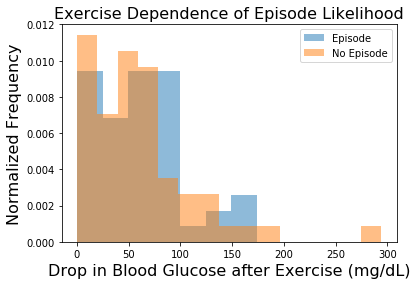

In [11]:
# Check trend of Exercise with episode
ex_id = df.columns.get_loc("ExDiff") 

hypo_yes = df[df['Episode'] == 1]
hypo_no = df[df['Episode'] == 0]

ex_yes = hypo_yes.iloc[:,ex_id].values
ex_no = hypo_no.iloc[:,ex_id].values
# exercise status

kwargs = dict(histtype='stepfilled', alpha=0.5, normed=True, bins='auto')

title('Exercise Dependence of Episode Likelihood', fontsize=16)
ylabel("Normalized Frequency", fontsize=16)
xlabel("Drop in Blood Glucose after Exercise (mg/dL)", fontsize=16)

plt.hist(ex_yes, **kwargs, label='Episode')
plt.hist(ex_no, **kwargs, label='No Episode')
plt.legend()

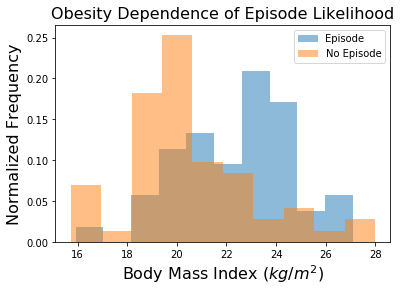

In [12]:
# Check trend of BMI with episode
bmi_id = df.columns.get_loc("BMI") 

hypo_yes = df[df['Episode'] == 1]
hypo_no = df[df['Episode'] == 0]

bmi_yes = hypo_yes.iloc[:,bmi_id].values
bmi_no = hypo_no.iloc[:,bmi_id].values
# BMI

kwargs = dict(histtype='stepfilled', alpha=0.5, normed=True, bins=10)

plt.hist(bmi_yes, **kwargs, label='Episode')
plt.hist(bmi_no, **kwargs, label='No Episode')

title('Obesity Dependence of Episode Likelihood', fontsize=16)
ylabel("Normalized Frequency", fontsize=16)
xlabel(r"Body Mass Index $(kg/m^2)$", fontsize=16)
plt.legend()

('10', 'Basal continued')


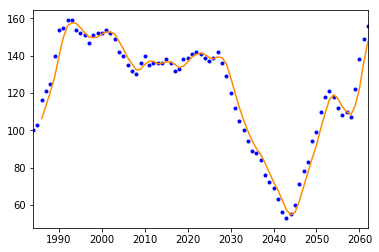

('10', 'Basal stopped')


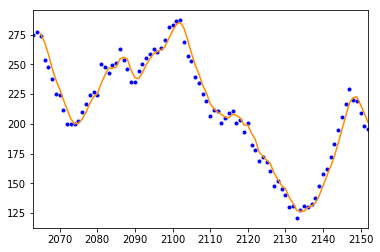

('11', 'Basal continued')


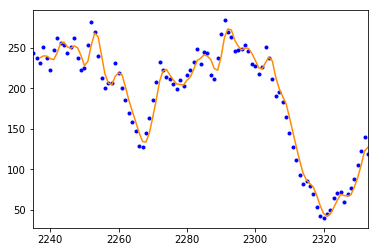

('11', 'Basal stopped')


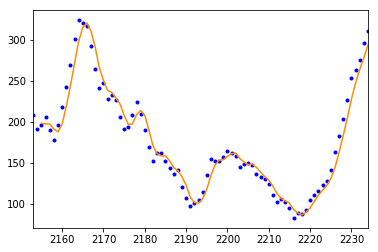

('12', 'Basal stopped')


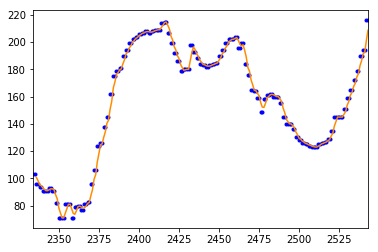

('13', 'Basal continued')


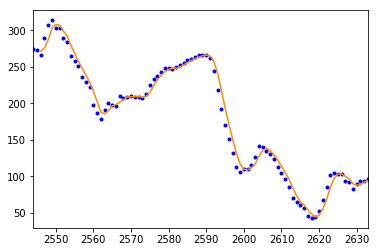

('13', 'Basal stopped')


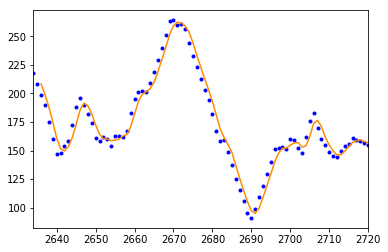

('14', 'Basal continued')


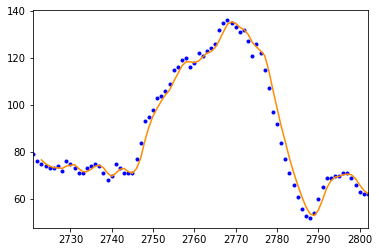

('14', 'Basal stopped')


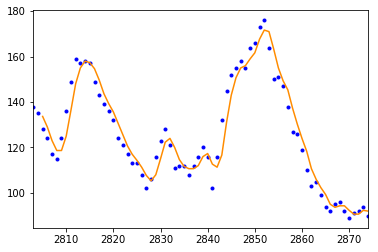

('15', 'Basal continued')


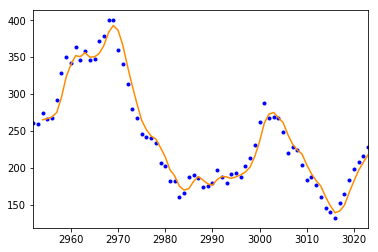

('15', 'Basal stopped')


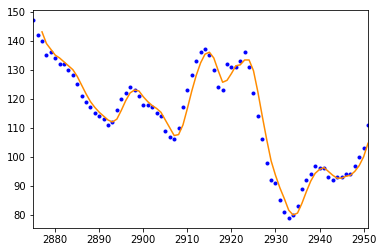

('16', 'Basal continued')


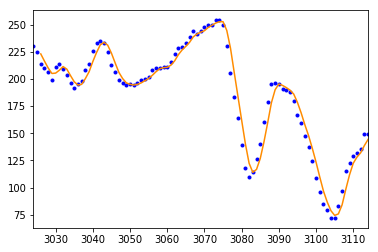

('17', 'Basal continued')


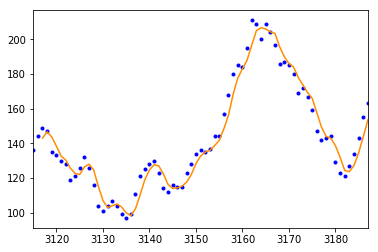

('17', 'Basal stopped')


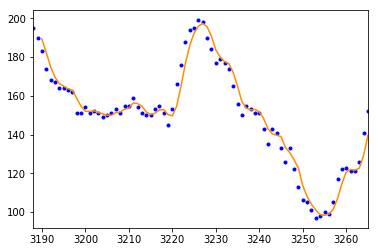

('18', 'Basal continued')


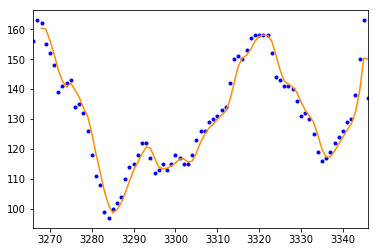

('18', 'Basal stopped')


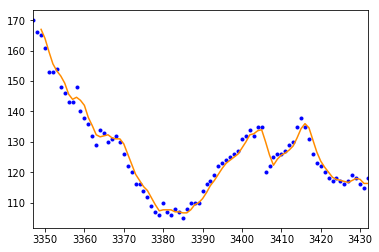

('19', 'Basal continued')


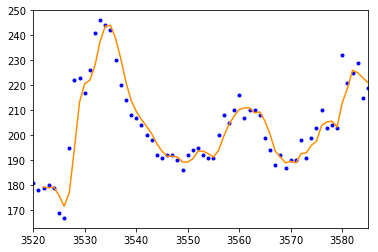

('19', 'Basal stopped')


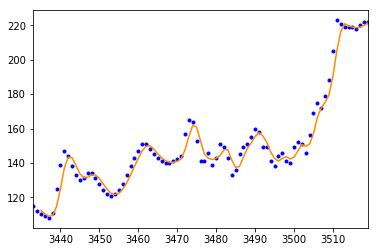

('2', 'Basal stopped')


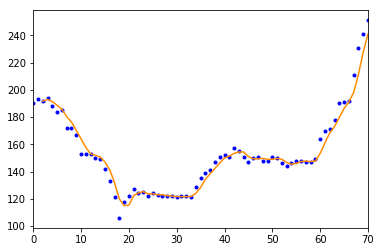

('20', 'Basal continued')


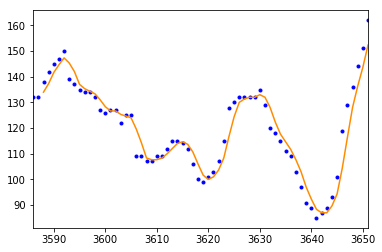

('20', 'Basal stopped')


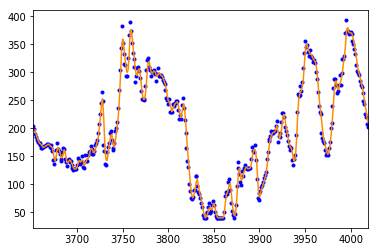

('21', 'Basal continued')


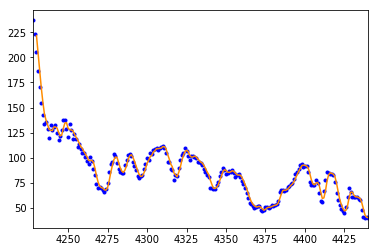

('21', 'Basal stopped')


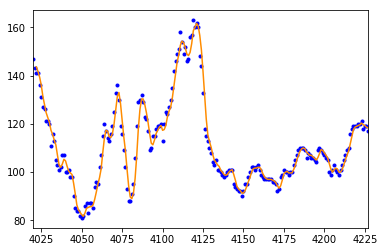

('22', 'Basal continued')


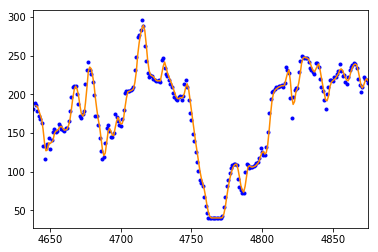

('22', 'Basal stopped')


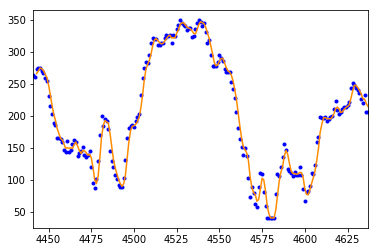

('23', 'Basal continued')


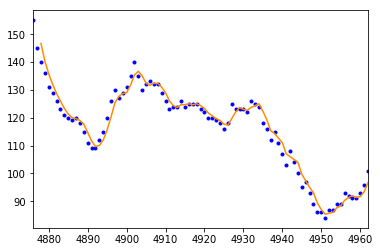

('23', 'Basal stopped')


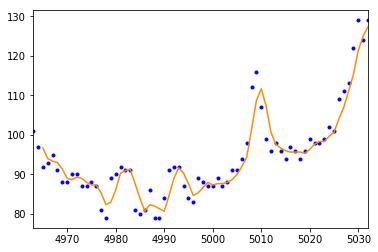

('24', 'Basal continued')


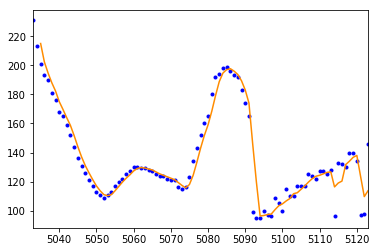

('24', 'Basal stopped')


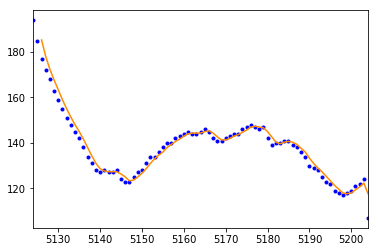

('25', 'Basal continued')


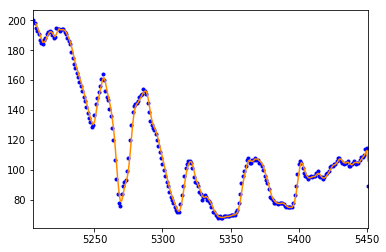

('25', 'Basal stopped')


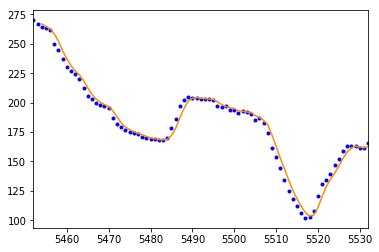

('26', 'Basal continued')


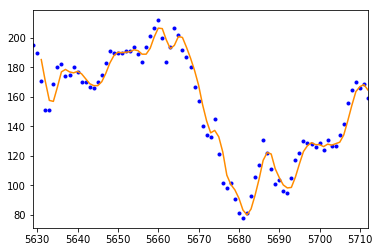

('26', 'Basal stopped')


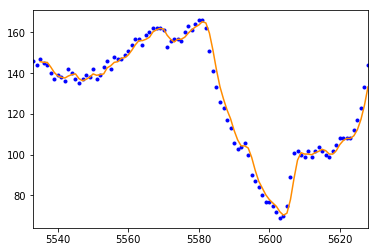

('27', 'Basal continued')


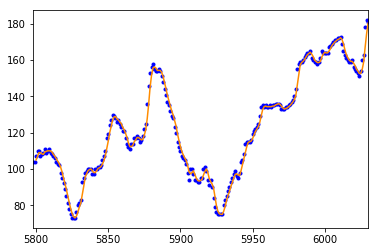

('27', 'Basal stopped')


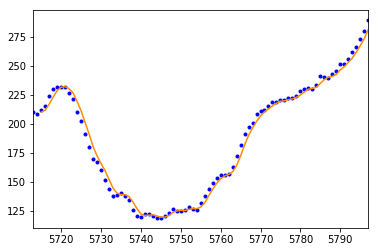

('28', 'Basal continued')


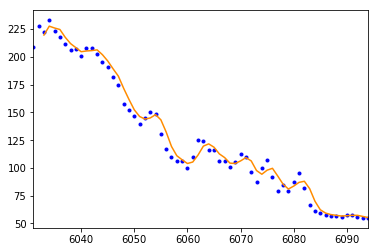

('28', 'Basal stopped')


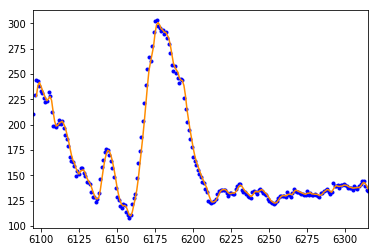

('29', 'Basal continued')


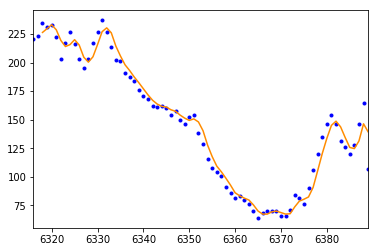

('29', 'Basal stopped')


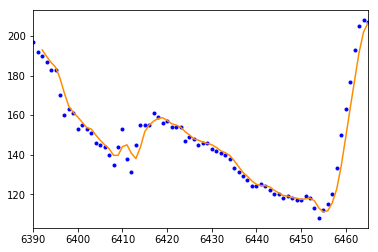

('3', 'Basal continued')


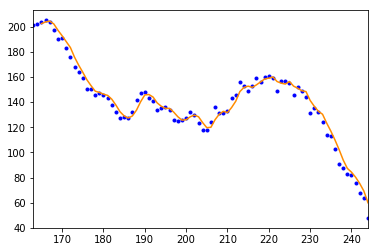

('3', 'Basal stopped')


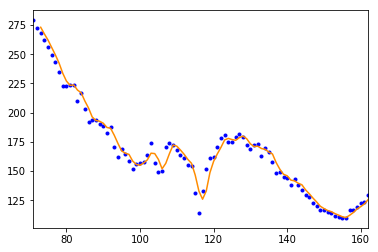

('30', 'Basal continued')


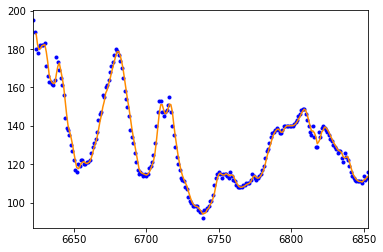

('30', 'Basal stopped')


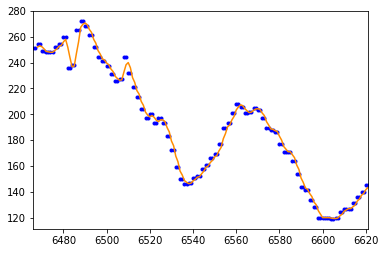

('31', 'Basal continued')


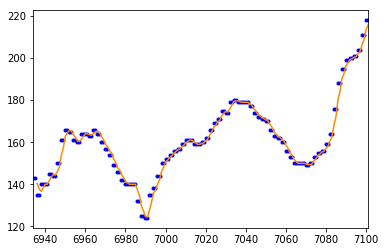

('31', 'Basal stopped')


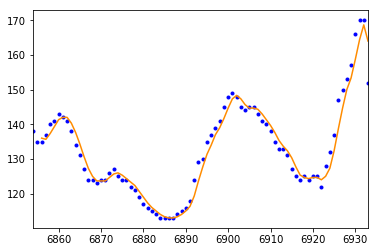

('32', 'Basal continued')


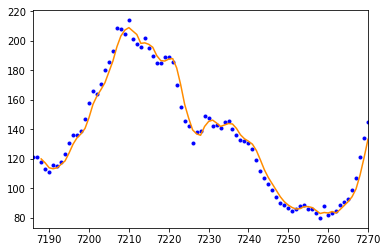

('32', 'Basal stopped')


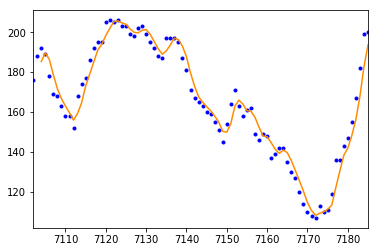

('33', 'Basal continued')


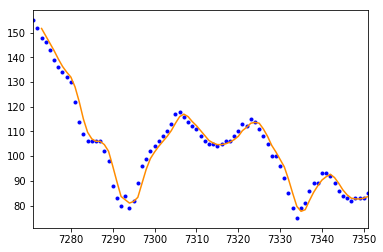

('33', 'Basal stopped')


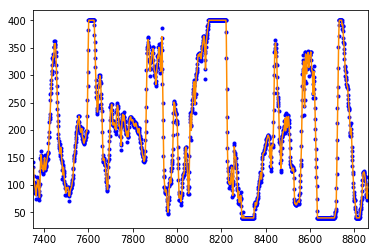

('34', 'Basal continued')


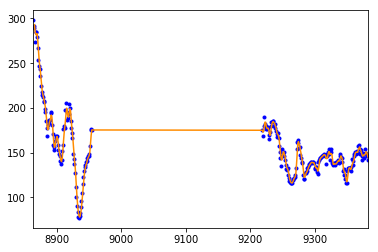

('34', 'Basal stopped')


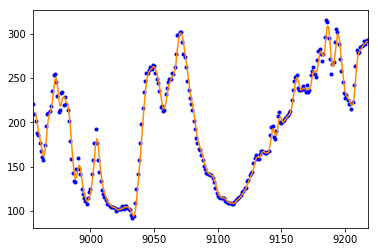

('35', 'Basal continued')


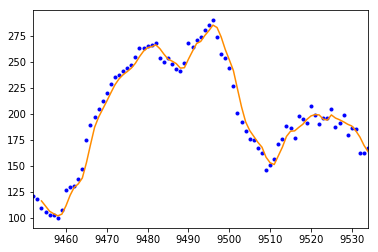

('35', 'Basal stopped')


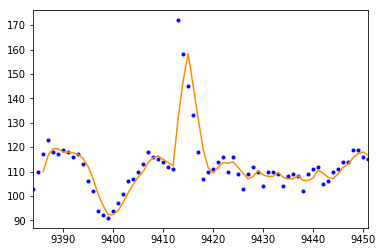

('36', 'Basal continued')


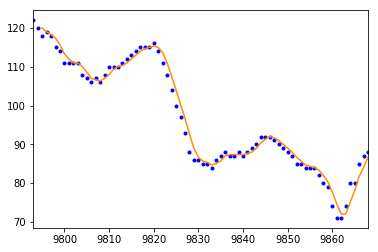

('36', 'Basal stopped')


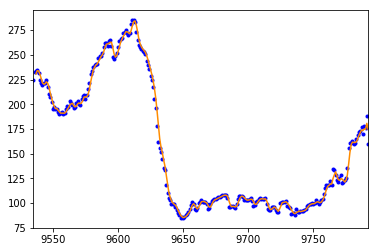

('37', 'Basal continued')


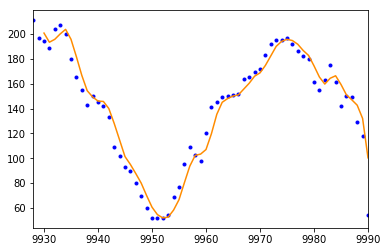

('37', 'Basal stopped')


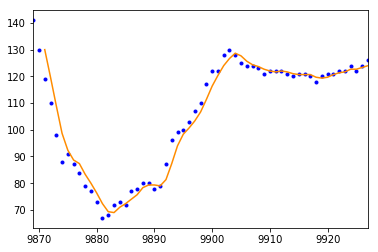

('38', 'Basal continued')


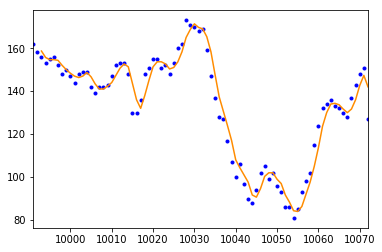

('38', 'Basal stopped')


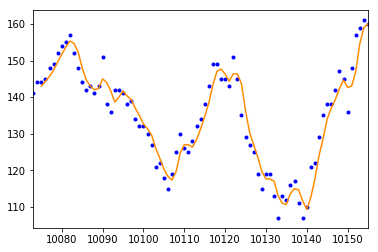

('39', 'Basal continued')


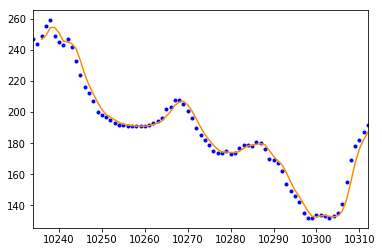

('39', 'Basal stopped')


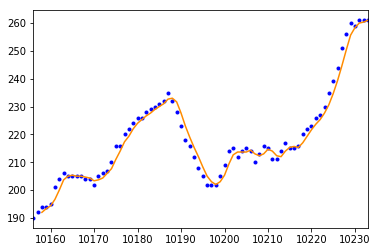

('4', 'Basal continued')


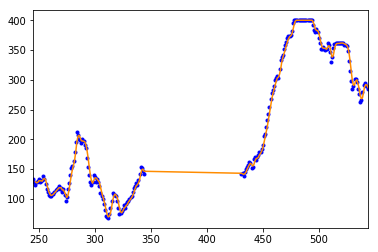

('4', 'Basal stopped')


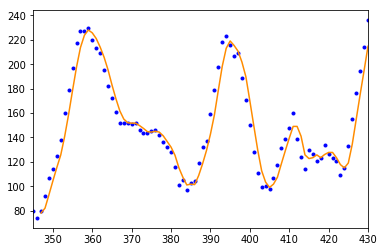

('40', 'Basal continued')


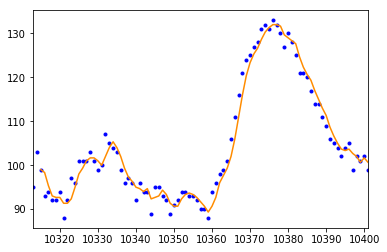

('40', 'Basal stopped')


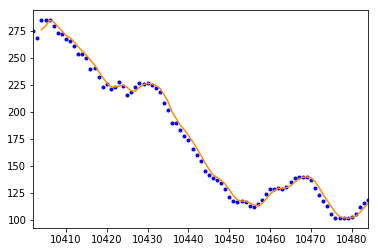

('41', 'Basal continued')


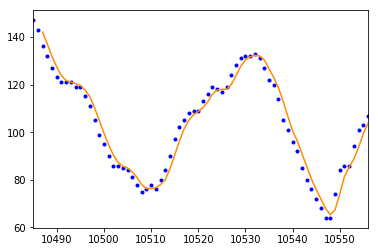

('41', 'Basal stopped')


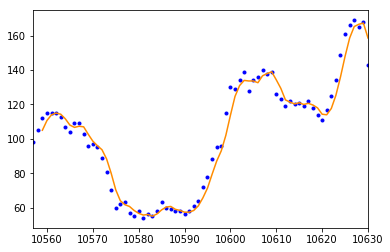

('42', 'Basal continued')


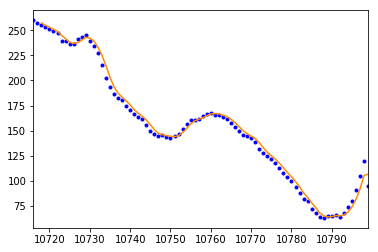

('42', 'Basal stopped')


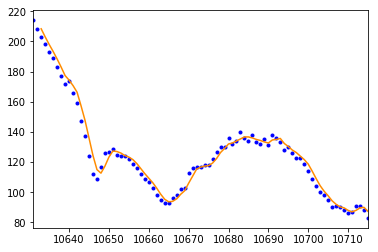

('43', 'Basal continued')


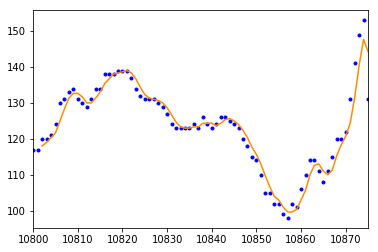

('43', 'Basal stopped')


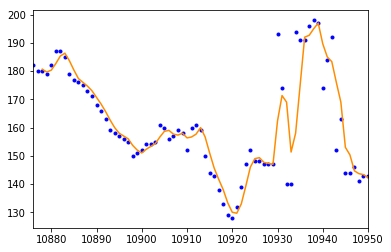

('44', 'Basal continued')


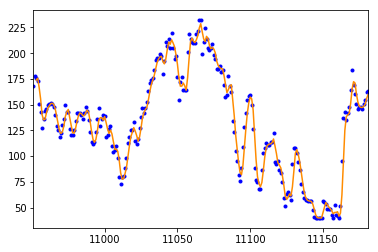

('44', 'Basal stopped')


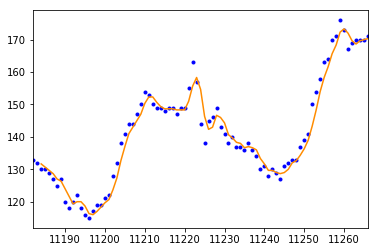

('45', 'Basal continued')


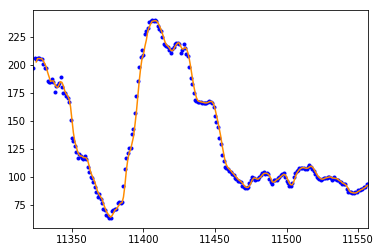

('45', 'Basal stopped')


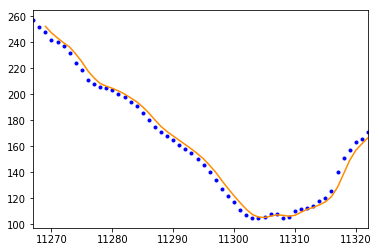

('46', 'Basal continued')


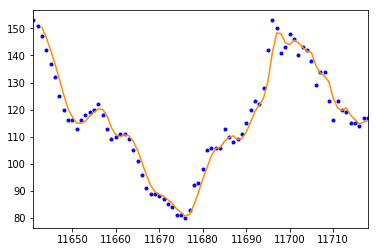

('46', 'Basal stopped')


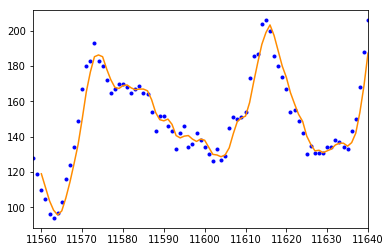

('47', 'Basal continued')


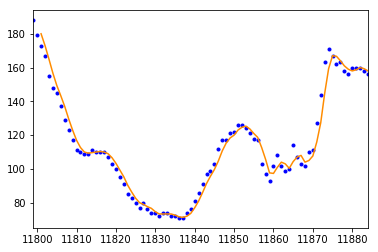

('47', 'Basal stopped')


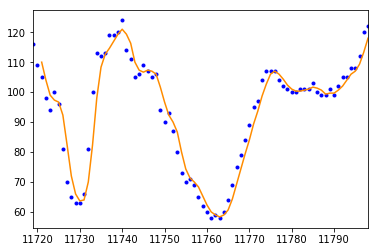

('48', 'Basal continued')


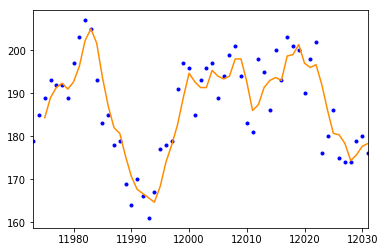

('48', 'Basal stopped')


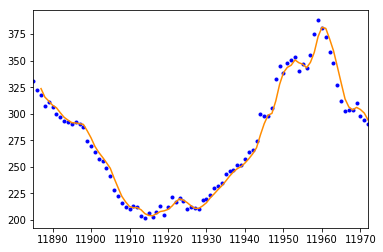

('49', 'Basal continued')


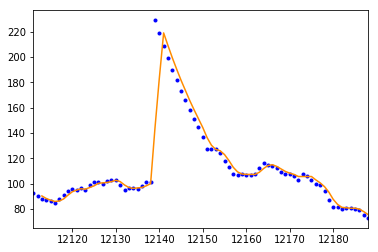

('49', 'Basal stopped')


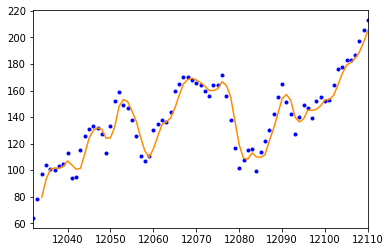

('5', 'Basal stopped')


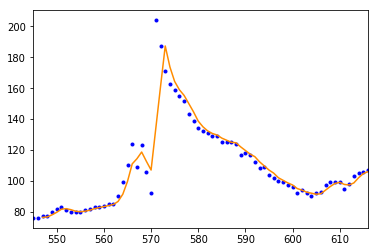

('51', 'Basal continued')


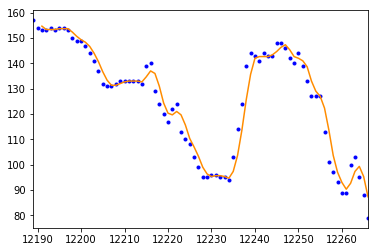

('51', 'Basal stopped')


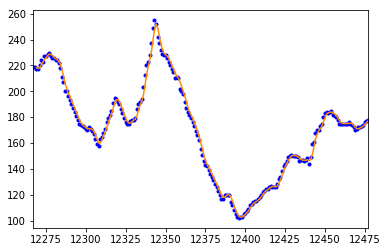

('52', 'Basal continued')


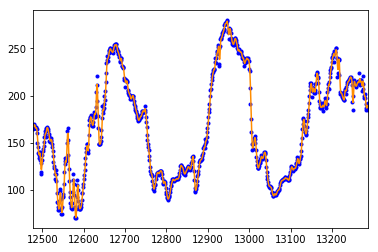

('52', 'Basal stopped')


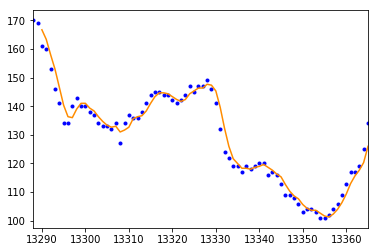

('53', 'Basal continued')


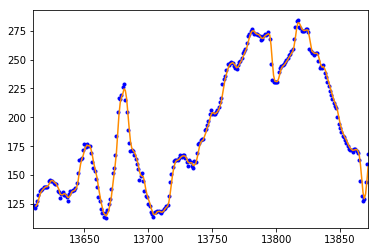

('53', 'Basal stopped')


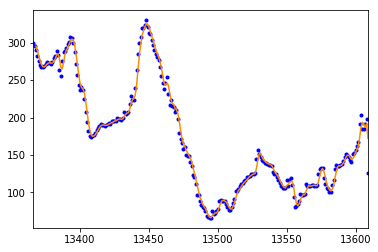

('54', 'Basal continued')


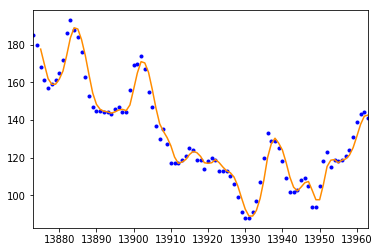

('54', 'Basal stopped')


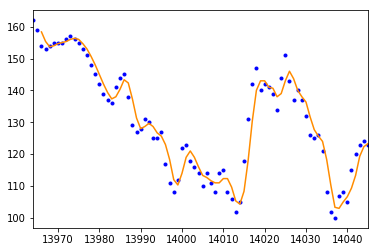

('55', 'Basal continued')


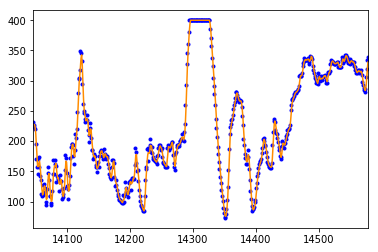

('55', 'Basal stopped')


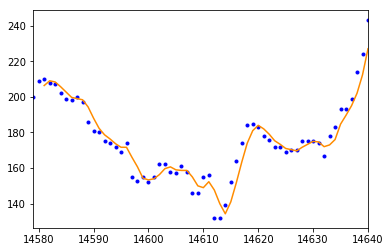

('56', 'Basal continued')


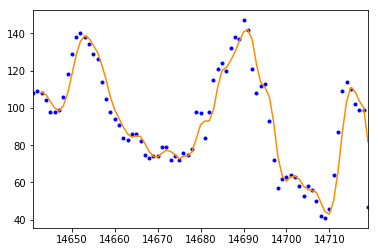

('56', 'Basal stopped')


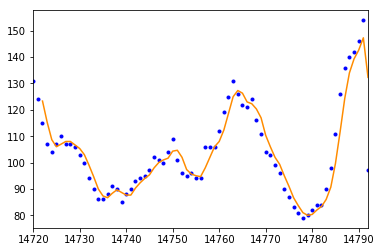

('57', 'Basal continued')


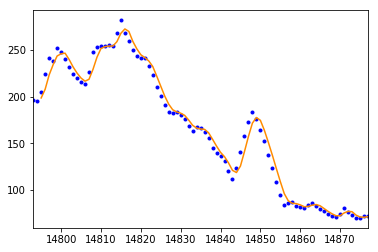

('57', 'Basal stopped')


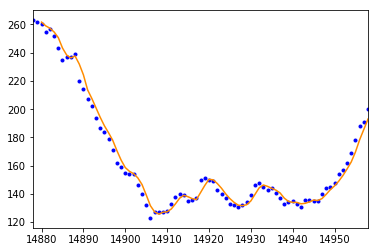

('6', 'Basal continued')


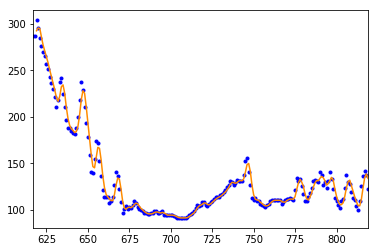

('6', 'Basal stopped')


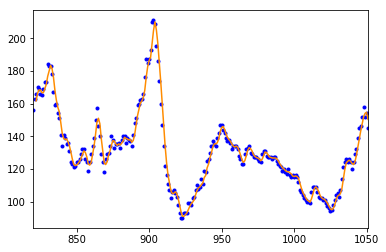

('7', 'Basal continued')


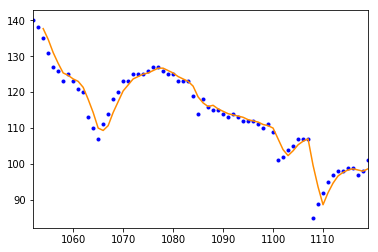

('8', 'Basal continued')


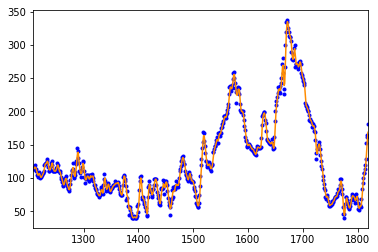

('8', 'Basal stopped')


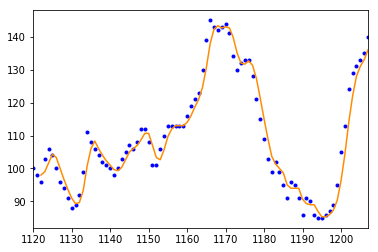

('9', 'Basal continued')


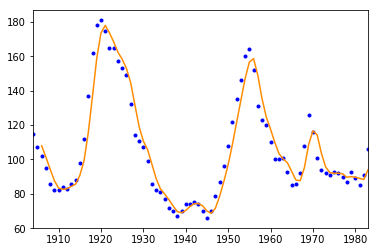

('9', 'Basal stopped')


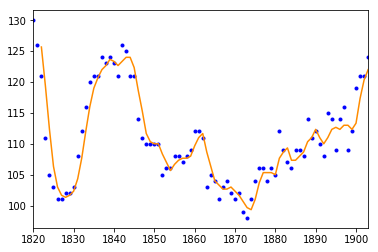

In [13]:
from pandas import Series

for name, group in df_cgms.groupby(['PtID', 'GVisitType']):
    print(name)
    series = group['SensorGLU']
# Tail-rolling average transform
    rolling = series.rolling(window=3)
    rolling_mean = rolling.mean()
    
# plot original and transformed dataset
    series.plot(c='blue', marker='.', ls='')
    rolling_mean.plot(color='darkorange')
    pyplot.show()